# Volume 4: Total Variation
    Daniel Perkins
    MATH 439
    1/16/25

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from imageio.v3 import imread, imwrite
from numpy.random import randint, uniform, randn


# Problem 1

Using $20$ $x$ steps, $250$ time steps, $a=-1$, $b=1$, $\alpha = 1$, $\beta=7$, and a final time of $0.2$, plot the solution that minimizes (17.4). It should match figure 17.1.

Difference in iterations is  0.0
Final time =  0.2


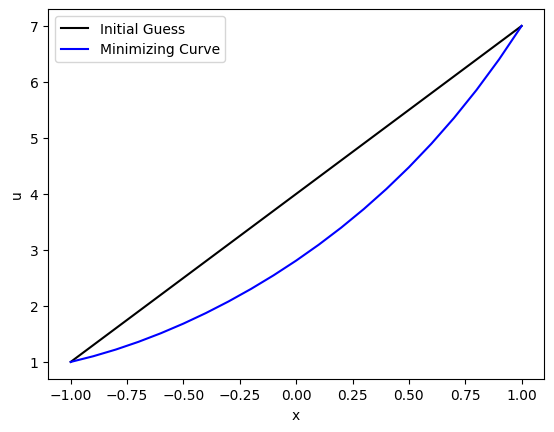

In [4]:
# Set up initial variables
a, b = -1., 1.
alpha, beta = 1, 7
num_x_steps = 20
num_time_steps = 250
xs = np.linspace(a, b, num_x_steps+1)
ts = np.linspace(0, 0.2, num_time_steps+1)
delta_x = xs[1] - xs[0]
delta_t = ts[1] - ts[0]

# Check the stability condition
if delta_t/delta_x**2. > .5: print("Stability Condition Fails")

# Set up initial data
u = np.empty((2, num_x_steps+1))
u[0] = (beta - alpha)/(b-a)*(xs-a) + alpha
u[1] = (beta - alpha)/(b-a)*(xs-a) + alpha
initial_guess = u.copy()

# Define right hand side of difference scheme
def rhs(y):
    # Approximate first and second derivatives to second order accuracy
    yp = (np.roll(y, -1) - np.roll(y, 1)) / (2.*delta_x)
    ypp = (np.roll(y, -1) - 2.*y + np.roll(y, 1))/ (delta_x**2)
    # Find approximation for the next time step, using a first order Euler step
    y[1:-1] -= delta_t*(1. + yp[1:-1]**2. - 1.*y[1:-1]*ypp[1:-1])
    return y

# Time step until successive iterations are close
iteration = 0
while iteration < num_time_steps:
    u[1] = rhs(u[1])
    if norm(np.abs((u[0]-u[1]))) < 1e-5: break
    u[0] = u[1]
    iteration += 1
    
print("Difference in iterations is ", norm(np.abs((u[0] - u[1]))))
print("Final time = ", iteration*delta_t)

# Plot it
plt.plot(xs, initial_guess[1], color="Black", label="Initial Guess")
plt.plot(xs, u[1], color="Blue", label="Minimizing Curve")
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.show()


# Problem 2

Using $\Delta t = 1e{-3},$ $\lambda = 40,$ $\Delta x = 1,$ and $\Delta y = 1$, implement the numerical scheme mentioned above to obtain a solution $u$. (So $\Omega = [0,n_x]\times [0,n_y]$, where $n_x$ and $n_y$ represent the number of pixels in the $x$ and $y$ dimensions, respectively.) Take 250 steps in time. Plot the original image as well as the image with noise. Compare your results with Figure 17.3.

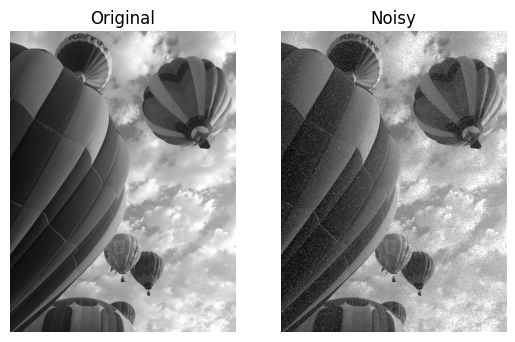

In [5]:
# Load in image
imagename = "balloons_color.jpg"
changed_pixels=40000
IM = imread(imagename, mode='F') * (1./255)
IM_original = np.copy(IM)
IM_x, IM_y = IM.shape

# Add noise
for lost in range(changed_pixels):
    x_, y_ = randint(1, IM_x-2), randint(1, IM_y-2)
    val = .1*randn() + .5
    IM[x_, y_] = max(min(val, 1.), 0.)

imwrite("noised_" + imagename, (IM * 255).astype(np.uint8))

# Plot it
plt.subplot(121)
plt.axis("off")
plt.title("Original")
plt.imshow(IM_original, cmap="gray")
plt.subplot(122)
plt.axis("off")
plt.title("Noisy")
plt.imshow(IM, cmap="gray")
plt.show()

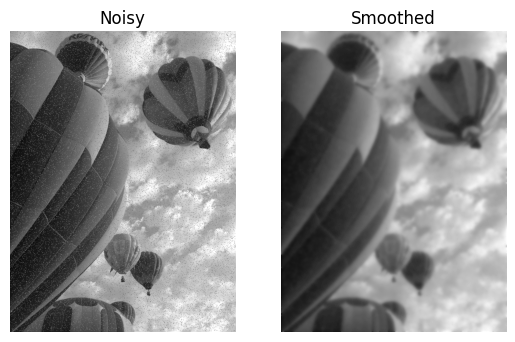

In [6]:
# Initial variables
delta_t = 1e-3
lam = 40
delta_x = 1
delta_y = 1
num_time_steps = 250

# Set up initial data
u = np.empty((2, IM_x, IM_y))
u[0], u[1] = IM, IM
initial_images = u.copy()

# Define right hand side of the differential equation
def rhs(u):
    # Approximate the second derivatives
    u_xx = np.roll(u, -1, axis=1) - 2*u + np.roll(u, 1, axis=1)
    u_yy = np.roll(u, -1, axis=0) - 2*u + np.roll(u, 1, axis=0)
    u[1:-1, 1:-1] -= delta_t*(u[1:-1, 1:-1] - IM[1:-1, 1:-1] - lam*(u_xx[1:-1, 1:-1] + u_yy[1:-1, 1:-1]))
    return u

# Time step until successive iterations are close
iteration = 0
while iteration < num_time_steps:
    u[1] = rhs(u[1])
    if norm(np.abs((u[0]-u[1]))) < 1e-5: break
    u[0] = u[1]
    iteration += 1
    
old = u.copy()  # Store it (for the next problem)
    
# Store smoothed image
imwrite("smoothed_" + imagename, (u[1] * 255).astype(np.uint8))

# Plot it
plt.subplot(121)
plt.axis("off")
plt.title("Noisy")
plt.imshow(initial_images[1], cmap="gray")
plt.subplot(122)
plt.axis("off")
plt.title("Smoothed")
plt.imshow(u[1], cmap="gray")
plt.show()

# Problem 3

Using $\Delta t = 1e-3, \lambda = 1, \Delta x = 1,$ and $ \Delta y = 1$, implement the numerical scheme mentioned above to obtain a solution $u$.  Take 200 steps in time. Display both the diffusion-based and total variaton images of the balloon. Compare your results with
Figure 17.3. How small should ε be?

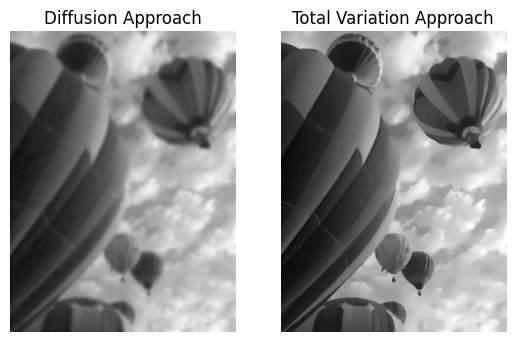

In [13]:
# Initial variables
delta_t = 1e-3
lam = 1
delta_x = 1
delta_y = 1
num_time_steps = 200
eps = 1e-6

# Set up initial data
u = np.empty((2, IM_x, IM_y))
u[0], u[1] = IM, IM
f = IM.copy()

# Define right hand side of the differential equation
def rhs(u):
    # Approximate the first derivatives
    u_x = (np.roll(u, -1, axis=1) - np.roll(u, 1, axis=1))/2
    u_y = (np.roll(u, -1, axis=0) - np.roll(u, 1, axis=0))/2
    
    # Approximate the second derivatives
    u_xx = np.roll(u, -1, axis=1) - 2*u + np.roll(u, 1, axis=1)
    u_yy = np.roll(u, -1, axis=0) - 2*u + np.roll(u, 1, axis=0)
    u_xy = (np.roll(u_x, -1, axis=0) - np.roll(u_x, 1, axis=0))/2
    
    # Equation 18.11
    numerator = u_xx*u_y**2 + u_yy*u_x**2 - 2*u_x*u_y*u_xy
    denominator = (eps + u_x**2 + u_y**2)**(3/2)
    right = -lam*(u-f) + numerator / denominator
    u += delta_t*right
    return u

# Time step until successive iterations are close
iteration = 0
while iteration < num_time_steps:
    u[1] = rhs(u[1])
    if norm(np.abs((u[0]-u[1]))) < 1e-5: break
    # print(norm(np.abs((u[0]-u[1]))))
    u[0] = u[1]
    iteration += 1
    
# Store smoothed image
imwrite("smoothed2_" + imagename, (u[1] * 255).astype(np.uint8))

# Plot it
plt.subplot(121)
plt.axis("off")
plt.title("Diffusion Approach")
plt.imshow(old[1], cmap="gray")
plt.subplot(122)
plt.axis("off")
plt.title("Total Variation Approach")
plt.imshow(u[1], cmap="gray")
plt.show()